# Programming Assignment 4: Clustering Analysis

## Question 1: Feature Extraction from ResNet18


In [20]:
import os
import ssl
import warnings
import xml.etree.ElementTree as ET
from collections import OrderedDict
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.cluster import (
    DBSCAN,
    AgglomerativeClustering,
    BisectingKMeans,
    KMeans,
    SpectralClustering,
)
from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from torch.utils.data import DataLoader, Dataset

ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore")

In [21]:
CROP_DIMENSION = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 32
EDGE_HISTOGRAM_BINS = 36
EDGE_MAGNITUDE_THRESHOLD = 30

DOG_CLASSES = [
    "n02089078-black-and-tan_coonhound",
    "n02091831-Saluki",
    "n02092002-Scottish_deerhound",
    "n02095314-wire-haired_fox_terrier",
]


class ImageDirectoryStructure:
    def __init__(self, base_path="./"):
        self.base_image_dir = os.path.join(base_path, "Dataset/Images")
        self.base_annotation_dir = os.path.join(base_path, "Dataset/Annotation")
        self.cropped_image_dir = os.path.join(base_path, "Assignment4/Cropped")
        Path(self.cropped_image_dir).mkdir(parents=True, exist_ok=True)


class EdgeHistogramExtractor:
    def __init__(
        self, num_bins=EDGE_HISTOGRAM_BINS, threshold=EDGE_MAGNITUDE_THRESHOLD
    ):
        self.num_bins = num_bins
        self.threshold = threshold

    def compute_histogram(self, img):
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        magnitude = np.sqrt(sobelx**2 + sobely**2)
        angle = np.arctan2(sobely, sobelx) * 180 / np.pi

        hist = np.zeros(self.num_bins)
        for i in range(magnitude.shape[0]):
            for j in range(magnitude.shape[1]):
                if magnitude[i, j] > self.threshold:
                    bin_idx = int((angle[i, j] + 180) * self.num_bins / 360)
                    if bin_idx == self.num_bins:
                        bin_idx = 0
                    hist[bin_idx] += magnitude[i, j]

        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

        return hist

    def process_directory(self, directory, class_labels):
        histograms = []
        labels = []

        for class_idx, dog_class in enumerate(class_labels):
            class_dir = os.path.join(directory, dog_class)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith(".jpg"):
                        img_path = os.path.join(class_dir, img_file)
                        img = cv2.imread(img_path)
                        hist = self.compute_histogram(img)
                        histograms.append(hist)
                        labels.append(class_idx)

        return np.array(histograms), np.array(labels)


class BoundingBoxExtractor:
    @staticmethod
    def extract_from_xml(annotation_file):
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        object_elements = root.findall("object")
        bounding_boxes = []

        for object_element in object_elements:
            box_element = object_element.find("bndbox")
            bounding_boxes.append(
                (
                    int(box_element.find("xmin").text),
                    int(box_element.find("ymin").text),
                    int(box_element.find("xmax").text),
                    int(box_element.find("ymax").text),
                )
            )
        return bounding_boxes


class ImageProcessor:
    def __init__(self, crop_size=CROP_DIMENSION):
        self.crop_size = crop_size

    def process_image(self, image_path, annotation_path, output_directory):
        original_image = Image.open(image_path)
        bounding_boxes = BoundingBoxExtractor.extract_from_xml(annotation_path)
        cropped_images = []

        for box_index, box in enumerate(bounding_boxes):
            cropped_image = original_image.crop(box)
            resized_image = cropped_image.resize(
                (self.crop_size, self.crop_size), Image.Resampling.LANCZOS
            )

            image_filename = os.path.basename(image_path)
            save_path = os.path.join(output_directory, image_filename)
            resized_image.convert("RGB").save(save_path)
            cropped_images.append(cropped_image)

        return original_image, cropped_images


class DogImageDataset(Dataset):
    def __init__(self, cropped_image_directory, class_list):
        self.image_paths = []
        self.class_labels = []

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD),
            ]
        )

        for class_index, dog_class in enumerate(class_list):
            class_directory = os.path.join(cropped_image_directory, dog_class)
            if os.path.exists(class_directory):
                for image_file in os.listdir(class_directory):
                    if image_file.endswith(".jpg"):
                        self.image_paths.append(
                            os.path.join(class_directory, image_file)
                        )
                        self.class_labels.append(class_index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        transformed_image = self.transform(image)
        return transformed_image, self.class_labels[index]


class FeatureExtractor:
    def __init__(self, device):
        self.device = device
        self.model = self._initialize_resnet()

    def _initialize_resnet(self):
        resnet = models.resnet18(pretrained=True)
        feature_extractor = torch.nn.Sequential(*(list(resnet.children())[:-2]))
        return feature_extractor.to(self.device)

    def extract_features(self, dataloader):
        feature_list = []
        label_list = []

        self.model.eval()
        with torch.no_grad():
            for images, batch_labels in dataloader:
                images = images.to(self.device)
                feature_maps = self.model(images)
                batch_features = torch.mean(feature_maps, dim=[2, 3]).cpu().numpy()
                feature_list.extend(batch_features)
                label_list.extend(batch_labels.numpy())

        return torch.tensor(feature_list), torch.tensor(label_list)

In [22]:
directory_structure = ImageDirectoryStructure()
image_processor = ImageProcessor()
total_processed_images = 0

for dog_class in DOG_CLASSES:
    class_image_directory = os.path.join(directory_structure.base_image_dir, dog_class)
    class_annotation_directory = os.path.join(
        directory_structure.base_annotation_dir, dog_class
    )
    class_output_directory = os.path.join(
        directory_structure.cropped_image_dir, dog_class
    )

    Path(class_output_directory).mkdir(parents=True, exist_ok=True)

    for image_file in os.listdir(class_image_directory):
        if not image_file.endswith(".jpg"):
            continue

        image_path = os.path.join(class_image_directory, image_file)
        annotation_file = os.path.join(
            class_annotation_directory, image_file.replace(".jpg", "")
        )

        if not os.path.exists(annotation_file):
            print(f"Missing annotation for {image_file}")
            continue

        _, cropped_images = image_processor.process_image(
            image_path, annotation_file, class_output_directory
        )
        total_processed_images += len(cropped_images)

print(f"Total processed images: {total_processed_images}")

Total processed images: 794


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = DogImageDataset(directory_structure.cropped_image_dir, DOG_CLASSES)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

feature_extractor = FeatureExtractor(device)
extracted_features, extracted_labels = feature_extractor.extract_features(dataloader)

edge_extractor = EdgeHistogramExtractor()
edge_histograms, edge_histogram_labels = edge_extractor.process_directory(
    directory_structure.cropped_image_dir, DOG_CLASSES
)

## Question 2: Dimension Reduction

Perform dimension reduction on the dog image representation dataset to reduce

the dimension to 2.


In [25]:
TARGET_DIMENSIONS = 2
FIGURE_SIZE = (10, 8)
SCATTER_ALPHA = 0.6
SCATTER_COLORS = ["r", "g", "b", "y"]


class DimensionReducer:
    def __init__(self, n_components=TARGET_DIMENSIONS):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)

    def fit_transform(self, features):
        scaled_features = self.scaler.fit_transform(features)
        reduced_features = self.pca.fit_transform(scaled_features)
        return reduced_features

    def get_explained_variance(self):
        return self.pca.explained_variance_ratio_


class FeatureVisualizer:
    def __init__(self, figure_size=FIGURE_SIZE, colors=SCATTER_COLORS):
        self.figure_size = figure_size
        self.colors = colors

    def plot_reduced_features(self, features, labels, class_names):
        plt.figure(figsize=self.figure_size)

        for class_idx, class_name in enumerate(class_names):
            mask = labels == class_idx
            plt.scatter(
                features[mask, 0],
                features[mask, 1],
                c=self.colors[class_idx],
                label=class_name.split("-")[1],
                alpha=SCATTER_ALPHA,
            )

        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.title("PCA Visualization of Dog Image Features")
        plt.legend()
        plt.tight_layout()
        plt.show()

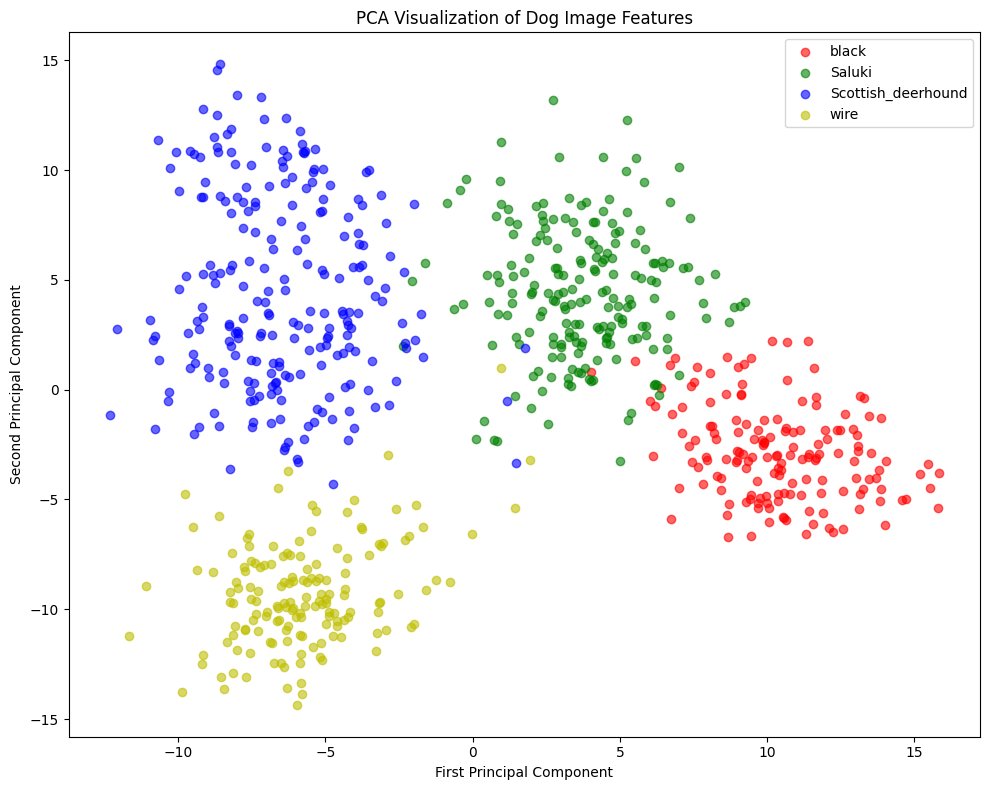

ResNet features explained variance ratio: [0.10093577 0.08116824]


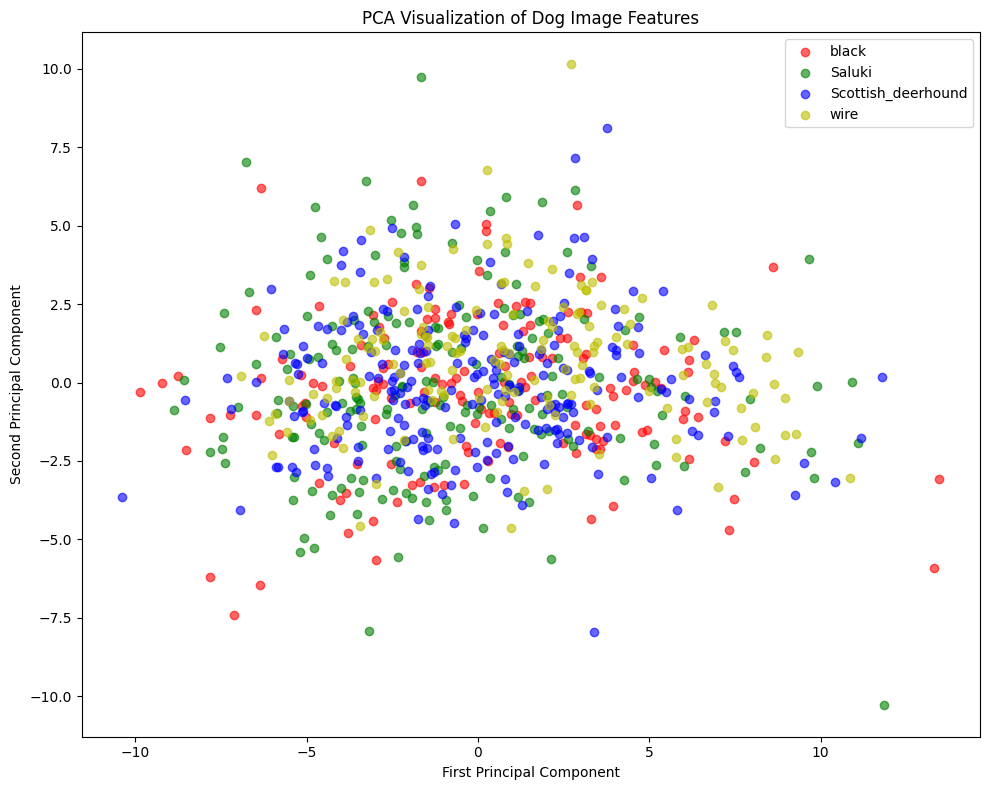

Edge histogram features explained variance ratio: [0.4557957  0.16319368]


In [26]:
dimension_reducer = DimensionReducer()
reduced_features = dimension_reducer.fit_transform(extracted_features)
explained_variance = dimension_reducer.get_explained_variance()

visualizer = FeatureVisualizer()
visualizer.plot_reduced_features(reduced_features, extracted_labels, DOG_CLASSES)

print("ResNet features explained variance ratio:", explained_variance)

edge_dimension_reducer = DimensionReducer()
reduced_edge_features = edge_dimension_reducer.fit_transform(edge_histograms)
edge_explained_variance = edge_dimension_reducer.get_explained_variance()

visualizer.plot_reduced_features(
    reduced_edge_features, edge_histogram_labels, DOG_CLASSES
)

print("Edge histogram features explained variance ratio:", edge_explained_variance)

## Question 3: Clustering Algorithms

Implement various clustering approaches on the 2D dataset:

- K-means variants (Random init, k-means++, Bisecting)

- Spectral clustering

- DBSCAN

- Agglomerative clustering with different linkage methods


In [28]:
CLUSTER_COUNT = 4
RANDOM_SEED = 42
FIGURE_SIZE = (10, 8)


class ClusterVisualizer:
    def __init__(self, figure_size=FIGURE_SIZE):
        self.figure_size = figure_size

    def plot_clusters(self, features, labels, algorithm_name):
        plt.figure(figsize=self.figure_size)
        unique_labels = np.unique(labels)
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

        for label, color in zip(unique_labels, colors):
            mask = labels == label
            label_name = "Noise" if label == -1 else f"Cluster {label}"
            plt.scatter(
                features[mask, 0], features[mask, 1], c=[color], label=label_name
            )

        plt.title(f"Clustering Results: {algorithm_name}")
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.legend()
        plt.tight_layout()
        plt.show()


class ClusteringAlgorithms:
    def __init__(self, n_clusters=CLUSTER_COUNT, random_state=RANDOM_SEED):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.visualizer = ClusterVisualizer()

    def kmeans_random(self, features):
        clusterer = KMeans(
            n_clusters=self.n_clusters,
            init="random",
            n_init=10,
            random_state=self.random_state,
        )
        labels = clusterer.fit_predict(features)
        self.visualizer.plot_clusters(features, labels, "K-means (Random Init)")
        return labels

    def kmeans_plus_plus(self, features):
        clusterer = KMeans(
            n_clusters=self.n_clusters,
            init="k-means++",
            n_init=10,
            random_state=self.random_state,
        )
        labels = clusterer.fit_predict(features)
        self.visualizer.plot_clusters(features, labels, "K-means++")
        return labels

    def bisecting_kmeans(self, features):
        clusterer = BisectingKMeans(
            n_clusters=self.n_clusters, init="random", random_state=self.random_state
        )
        labels = clusterer.fit_predict(features)
        self.visualizer.plot_clusters(features, labels, "Bisecting K-means")
        return labels

    def spectral(self, features):
        clusterer = SpectralClustering(
            n_clusters=self.n_clusters, random_state=self.random_state
        )
        labels = clusterer.fit_predict(features)
        self.visualizer.plot_clusters(features, labels, "Spectral Clustering")
        return labels

    def dbscan_optimal(self, features):
        best_eps = 0
        best_min_samples = 0
        best_score = -1
        best_labels = None

        eps_range = np.arange(0.1, 2.0, 0.1)
        min_samples_range = range(2, 10)

        for eps in eps_range:
            for min_samples in min_samples_range:
                clusterer = DBSCAN(eps=eps, min_samples=min_samples)
                labels = clusterer.fit_predict(features)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

                if n_clusters == self.n_clusters:
                    mask = labels != -1
                    if np.sum(mask) > 1:
                        from sklearn.metrics import silhouette_score

                        score = silhouette_score(features[mask], labels[mask])
                        if score > best_score:
                            best_score = score
                            best_eps = eps
                            best_min_samples = min_samples
                            best_labels = labels

        if best_labels is not None:
            print(
                f"Optimal DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}"
            )
            self.visualizer.plot_clusters(features, best_labels, "DBSCAN")
        else:
            print("Could not find DBSCAN parameters for exactly 4 clusters")
        return best_labels

    def agglomerative(self, features):
        linkage_methods = ["ward", "complete", "average", "single"]
        results = {}

        for linkage in linkage_methods:
            clusterer = AgglomerativeClustering(
                n_clusters=self.n_clusters, linkage=linkage
            )
            labels = clusterer.fit_predict(features)
            self.visualizer.plot_clusters(
                features, labels, f"Agglomerative Clustering ({linkage})"
            )
            results[linkage] = labels

        return results

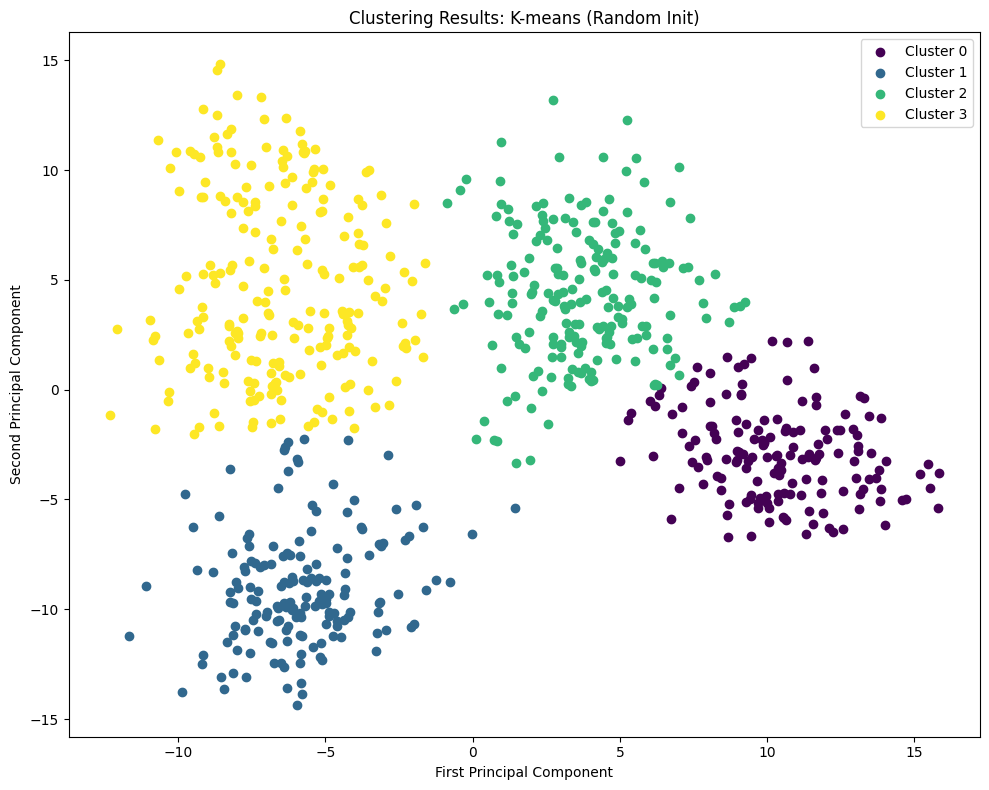

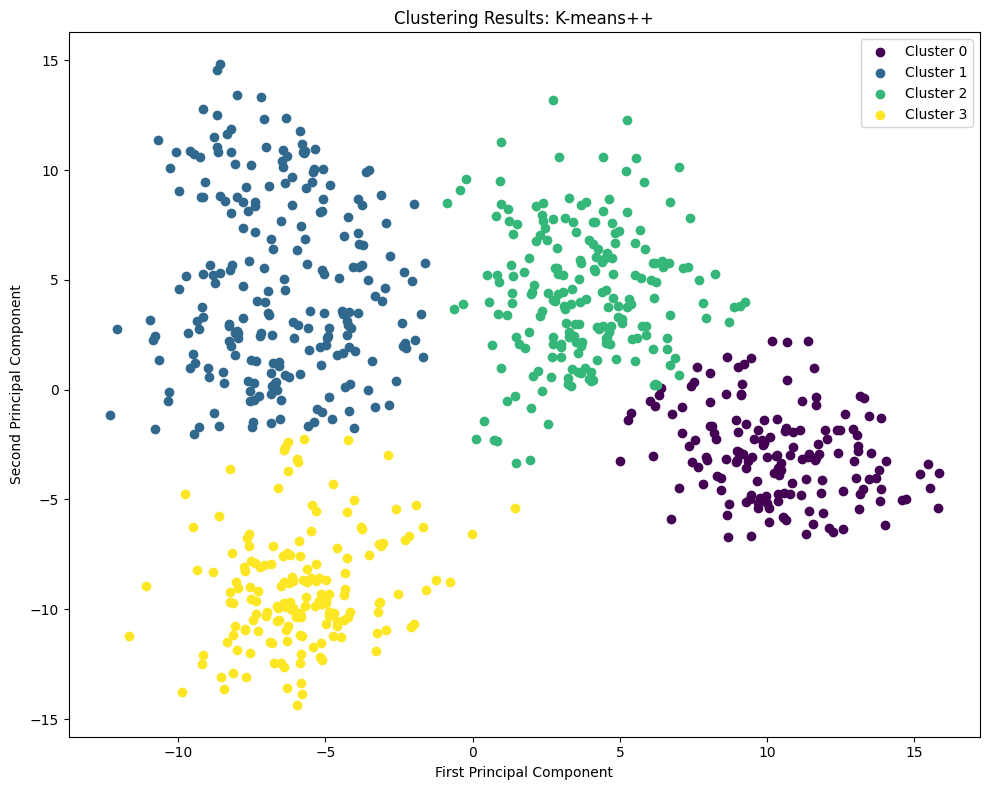

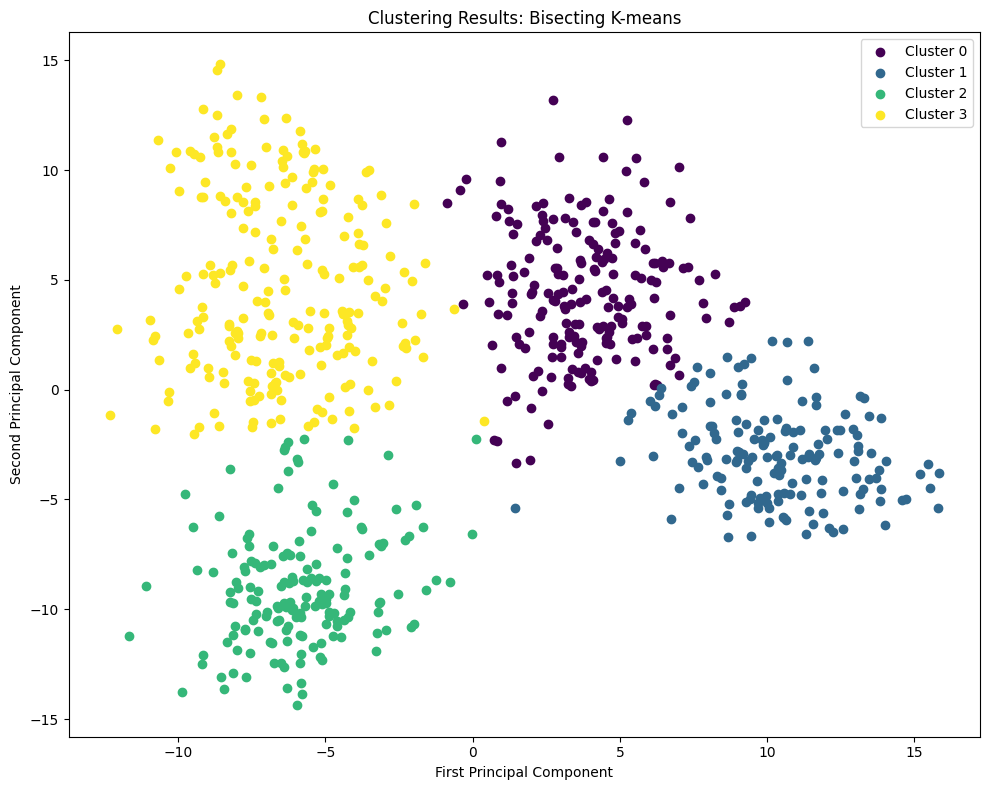

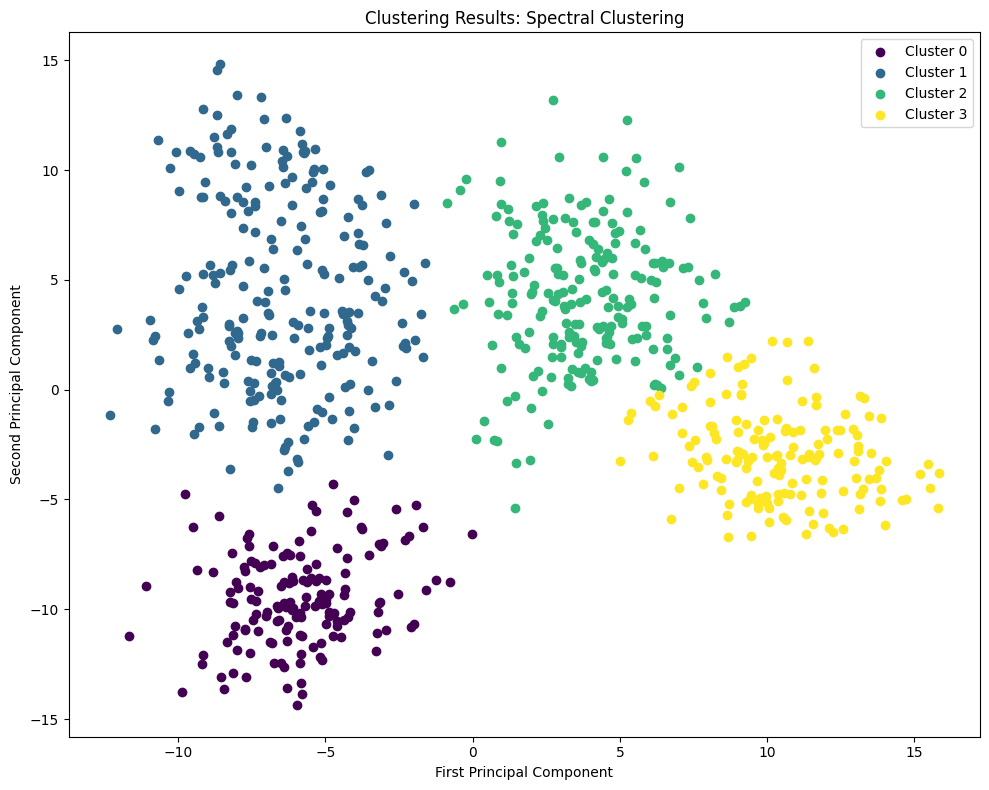

Optimal DBSCAN parameters: eps=1.3, min_samples=9


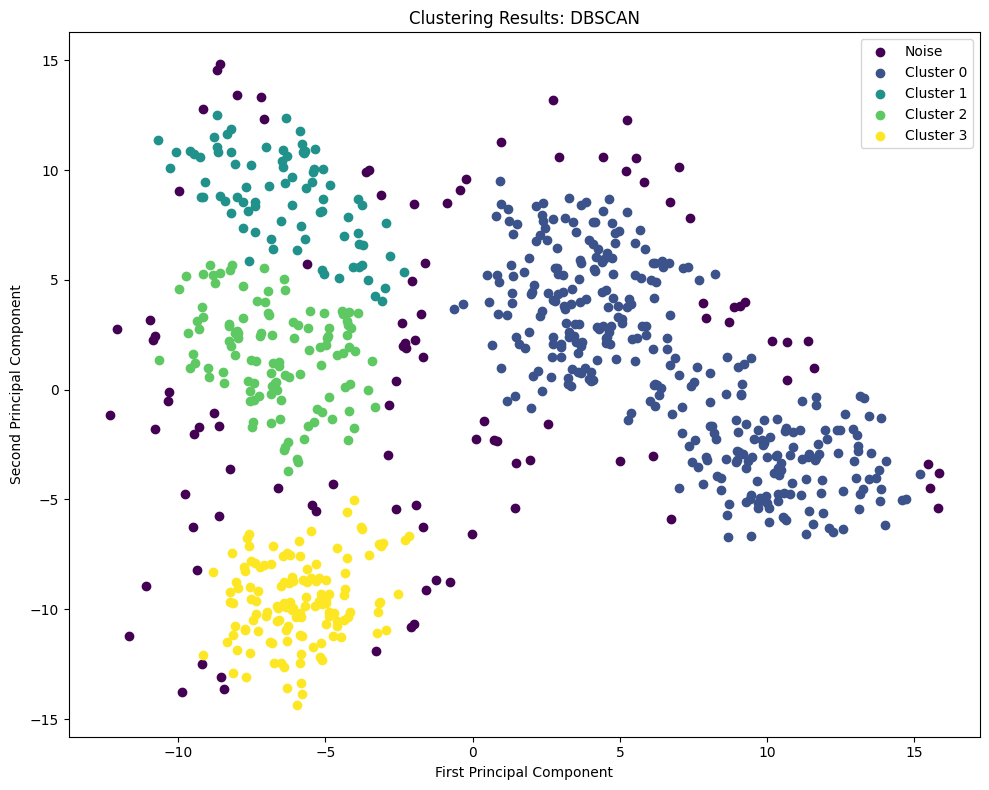

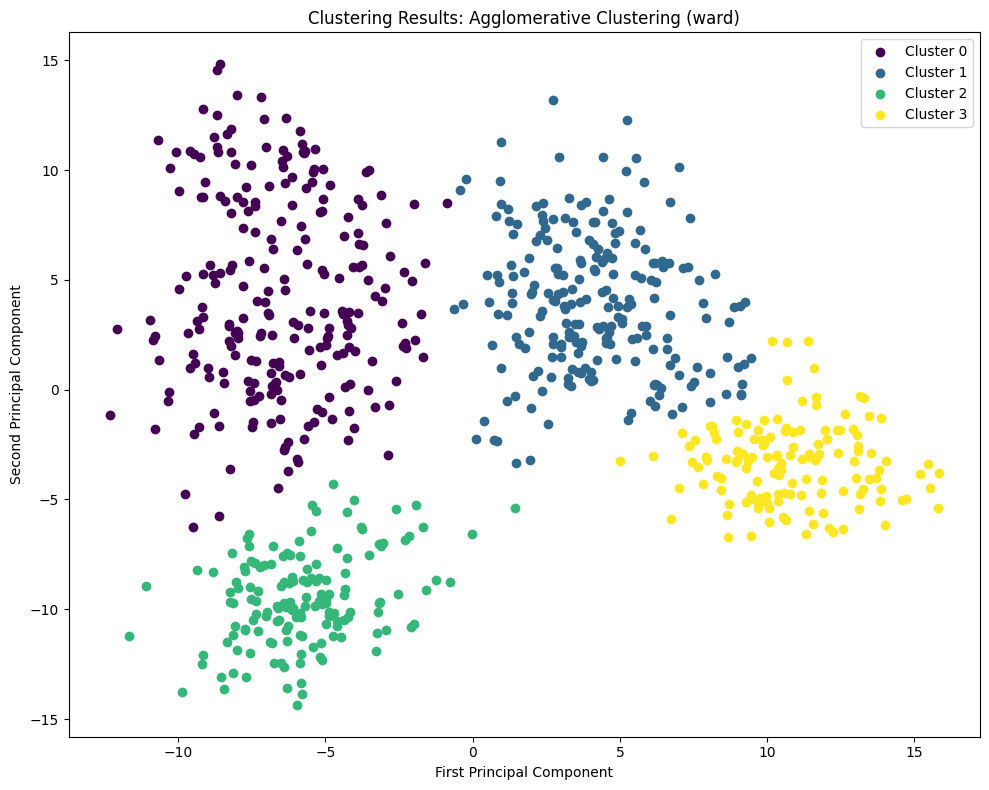

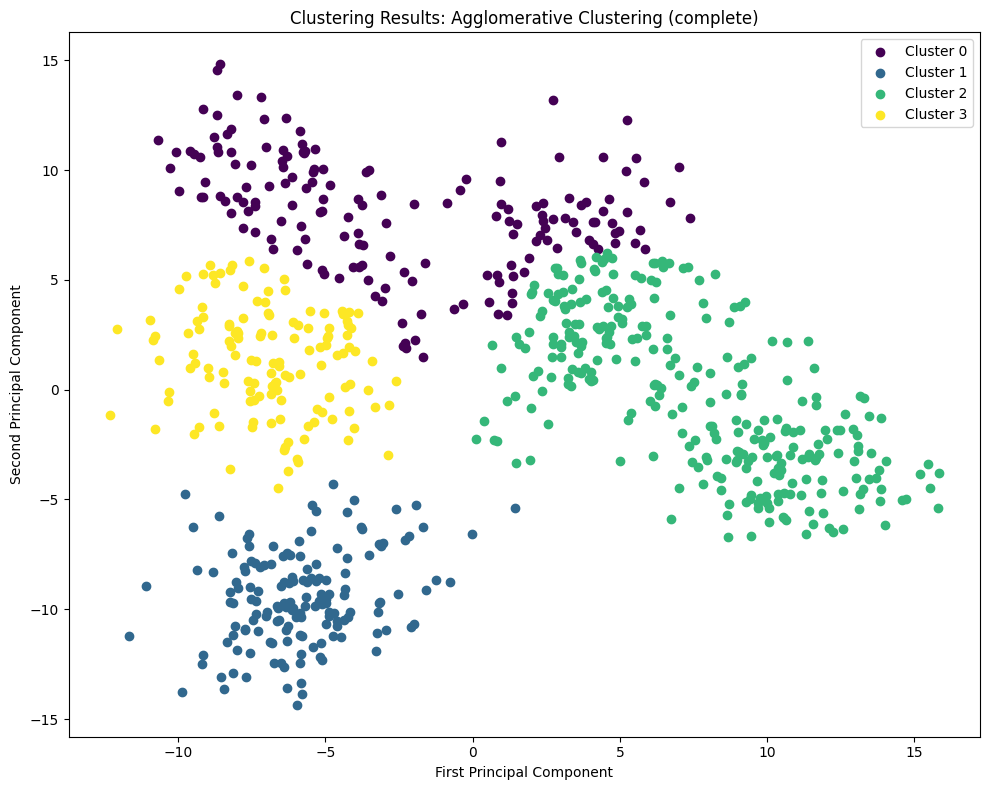

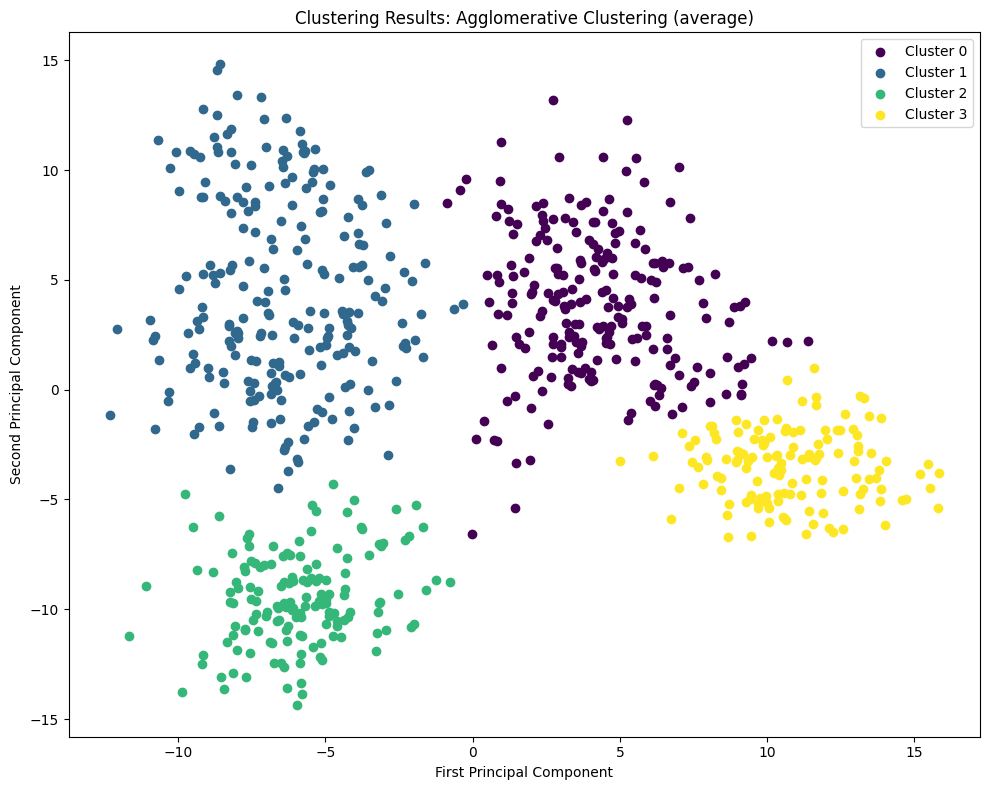

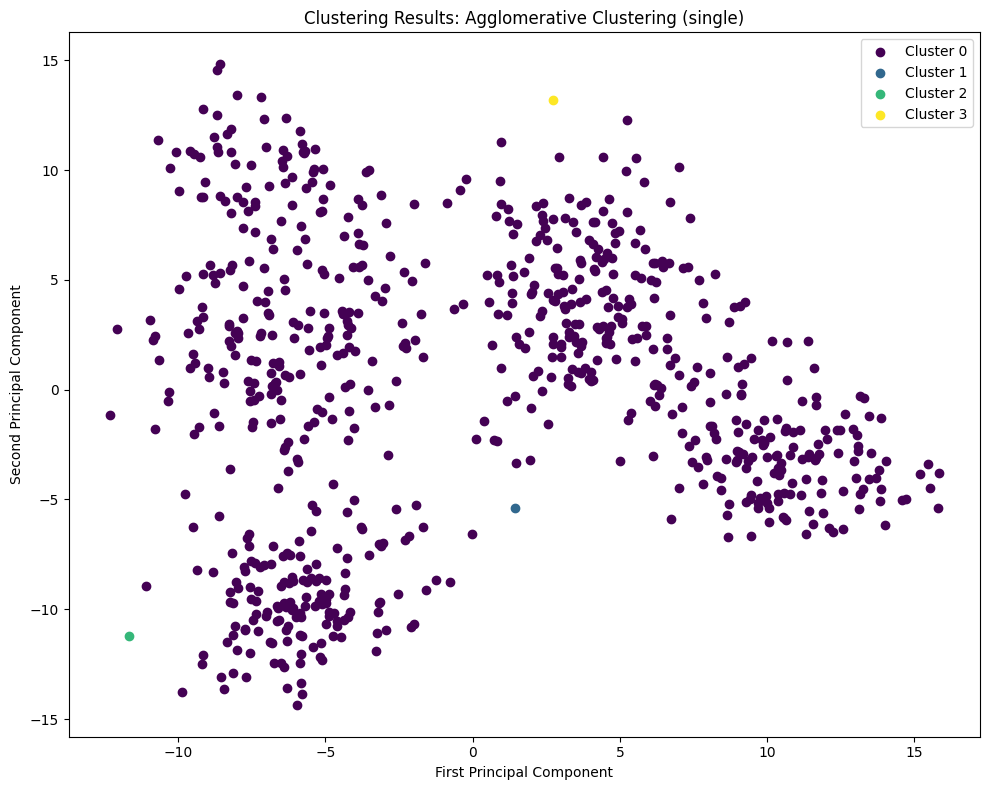

In [29]:
clustering = ClusteringAlgorithms()

kmeans_random_labels = clustering.kmeans_random(reduced_features)
kmeans_plus_labels = clustering.kmeans_plus_plus(reduced_features)
bisecting_labels = clustering.bisecting_kmeans(reduced_features)
spectral_labels = clustering.spectral(reduced_features)
dbscan_labels = clustering.dbscan_optimal(reduced_features)
agglomerative_results = clustering.agglomerative(reduced_features)

## Question 4: Clustering Evaluations

Evaluate clustering performance using:

- Fowlkes-Mallows index

- Silhouette Coefficient

Then rank all methods based on both metrics.


In [30]:
DECIMAL_PLACES = 4

In [31]:
class ClusteringEvaluator:
    def __init__(self, features, true_labels):
        self.features = features
        self.true_labels = true_labels
        self.results = OrderedDict()

    def evaluate_clustering(self, method_name, predicted_labels):
        if -1 in predicted_labels:
            mask = predicted_labels != -1
            fm_score = fowlkes_mallows_score(
                self.true_labels[mask], predicted_labels[mask]
            )
            silhouette = silhouette_score(self.features[mask], predicted_labels[mask])
        else:
            fm_score = fowlkes_mallows_score(self.true_labels, predicted_labels)
            silhouette = silhouette_score(self.features, predicted_labels)

        self.results[method_name] = (fm_score, silhouette)

    def print_results_table(self):
        headers = ["Method", "Fowlkes-Mallows", "Silhouette"]
        table_data = []

        for method, (fm, silhouette) in self.results.items():
            table_data.append(
                [method, f"{fm:.{DECIMAL_PLACES}f}", f"{silhouette:.{DECIMAL_PLACES}f}"]
            )

        print("\nClustering Evaluation Results:")
        print(tabulate(table_data, headers=headers, tablefmt="grid"))

    def print_rankings_table(self):
        fm_ranking = sorted(self.results.items(), key=lambda x: x[1][0], reverse=True)
        silhouette_ranking = sorted(
            self.results.items(), key=lambda x: x[1][1], reverse=True
        )

        fm_table = []
        silhouette_table = []

        for rank, (method, (fm, _)) in enumerate(fm_ranking, 1):
            fm_table.append([rank, method, f"{fm:.{DECIMAL_PLACES}f}"])

        for rank, (method, (_, silhouette)) in enumerate(silhouette_ranking, 1):
            silhouette_table.append([rank, method, f"{silhouette:.{DECIMAL_PLACES}f}"])

        print("\nRanking based on Fowlkes-Mallows index:")
        print(tabulate(fm_table, headers=["Rank", "Method", "Score"], tablefmt="grid"))

        print("\nRanking based on Silhouette Coefficient:")
        print(
            tabulate(
                silhouette_table, headers=["Rank", "Method", "Score"], tablefmt="grid"
            )
        )

In [32]:
evaluator = ClusteringEvaluator(reduced_features, extracted_labels)

evaluator.evaluate_clustering("K-means (Random)", kmeans_random_labels)
evaluator.evaluate_clustering("K-means++", kmeans_plus_labels)
evaluator.evaluate_clustering("Bisecting K-means", bisecting_labels)

evaluator.evaluate_clustering("Spectral", spectral_labels)

if dbscan_labels is not None:
    evaluator.evaluate_clustering("DBSCAN", dbscan_labels)

for linkage, labels in agglomerative_results.items():
    evaluator.evaluate_clustering(f"Agglomerative ({linkage})", labels)

evaluator.print_results_table()
evaluator.print_rankings_table()


Clustering Evaluation Results:
+--------------------------+-------------------+--------------+
| Method                   |   Fowlkes-Mallows |   Silhouette |
+==========================+===================+==============+
| K-means (Random)         |            0.934  |       0.5388 |
+--------------------------+-------------------+--------------+
| K-means++                |            0.934  |       0.5388 |
+--------------------------+-------------------+--------------+
| Bisecting K-means        |            0.9239 |       0.5362 |
+--------------------------+-------------------+--------------+
| Spectral                 |            0.9399 |       0.5351 |
+--------------------------+-------------------+--------------+
| DBSCAN                   |            0.7115 |       0.5181 |
+--------------------------+-------------------+--------------+
| Agglomerative (ward)     |            0.9029 |       0.5263 |
+--------------------------+-------------------+--------------+
| Agglom